# Prior Distributions for FLI

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Global Parameters


$\log \tau^{G} \sim \mathcal{N}(\ln(0.2), 0.7)$ -> 95% CI is approximately [0.05, 0.8]

$\log \sigma_{\tau^{G}} \sim \mathcal{N}(-1, 0.1)$ (variance of the local parameters in one picture)

$\log \Delta\tau^{G} \sim \mathcal{N}(\ln(1.2), 0.5)$

$\log \Delta\sigma_{\tau^{G}} \sim \mathcal{N}(-2, 0.1)$



$a \sim \text{Gamma}(1,1)$, $b \sim \text{Gamma}(1,1)$: $A^L \sim \text{Beta}(a, b)$ and we transform this to unbounded space by $\tilde{a}=\log(a)$, $\tilde{b}=\log(b)$.



In [66]:
class FLI_Prior:
    def __init__(self):
        self.tau1_mean_hyperprior_mean = np.log(0.2)
        self.tau1_mean_hyperprior_std = 0.7
        self.tau1_std_hyperprior_mean = -1
        self.tau1_std_hyperprior_std = 0.1

        self.delta_tau_mean_hyperprior_mean = np.log(1.2)
        self.delta_tau_mean_hyperprior_std = 0.5
        self.delta_tau_std_hyperprior_mean = -2
        self.delta_tau_std_hyperprior_std = 0.1

        self.alpha_hyperprior_a = 1
        self.alpha_hyperprior_b = 1
        self.beta_hyperprior_a = 1
        self.beta_hyperprior_b = 1

        self.sample_global()

    def sample_global(self):
        self.log_tau_G = np.random.normal(self.tau1_mean_hyperprior_mean, self.tau1_mean_hyperprior_std)
        self.log_sigma_tau_G = np.random.normal(self.tau1_std_hyperprior_mean, self.tau1_std_hyperprior_std)

        self.log_delta_tau_G = np.random.normal(self.delta_tau_mean_hyperprior_mean, self.delta_tau_mean_hyperprior_std)
        self.log_delta_sigma_tau_G = np.random.normal(self.delta_tau_std_hyperprior_mean, self.delta_tau_std_hyperprior_std)

        self.alpha_hyperprior = np.random.gamma(self.alpha_hyperprior_a, self.alpha_hyperprior_b)
        self.beta_hyperprior = np.random.gamma(self.beta_hyperprior_a, self.beta_hyperprior_b)

        return dict(log_tau_G=self.log_tau_G, log_sigma_tau_G=self.log_sigma_tau_G,
                    log_delta_tau_G=self.log_delta_tau_G, log_delta_sigma_tau_G=self.log_delta_sigma_tau_G,
                    alpha_hyperprior=self.alpha_hyperprior, beta_hyperprior=self.beta_hyperprior)

    def get_local_variances(self):
        var_tau_L = np.exp(2 * self.log_tau_G + np.exp(self.log_sigma_tau_G)**2) * (np.exp(np.exp(self.log_sigma_tau_G)**2) - 1)
        var_delta = np.exp(2 * self.log_delta_tau_G + np.exp(self.log_delta_sigma_tau_G)**2) * (np.exp(np.exp(self.log_delta_sigma_tau_G)**2) - 1)
        tau_L1_std = np.sqrt(var_tau_L)
        tau_L2_std = np.sqrt(var_tau_L + var_delta)
        return dict(tau_L1_std=tau_L1_std, tau_L2_std=tau_L2_std)


    def sample_local(self, n_local_samples):
        log_tau_L = np.random.normal(self.log_tau_G, np.exp(self.log_sigma_tau_G), size=n_local_samples)
        log_delta_tau_L = np.random.normal(self.log_delta_tau_G, np.exp(self.log_delta_sigma_tau_G), size=n_local_samples)
        A_L = np.random.beta(self.alpha_hyperprior, self.beta_hyperprior, size=n_local_samples)


        tau_L = np.exp(log_tau_L)
        tau_L_2 = tau_L + np.exp(log_delta_tau_L)
        a_l = np.log(A_L / (1 - A_L + 1e-8))
        return dict(tau_L=tau_L, tau_L_2=tau_L_2, A_L=A_L,
                    log_tau_L=log_tau_L, log_delta_tau_L=log_delta_tau_L, a_l=a_l)

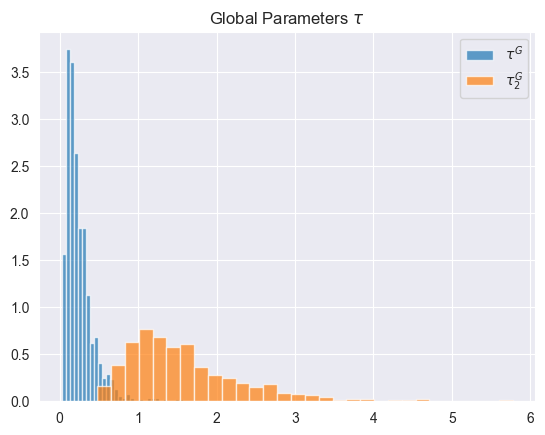

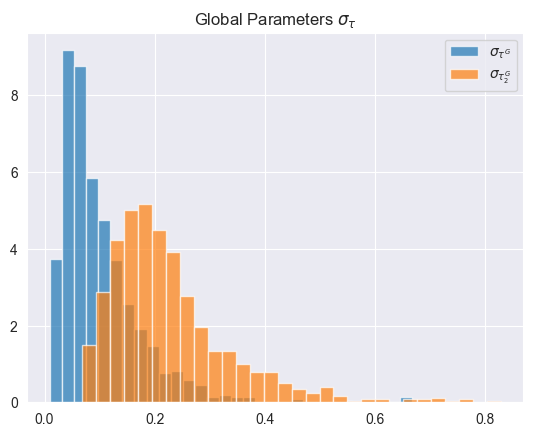

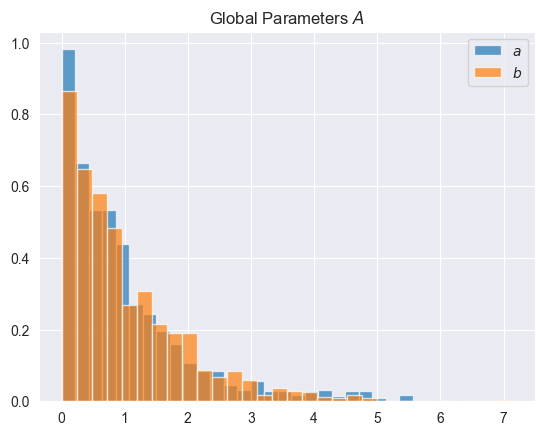

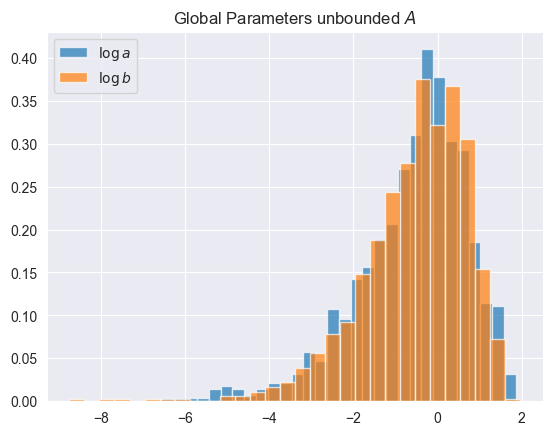

In [68]:
# distribution
n_global_samples = 1000

prior = FLI_Prior()

log_tau_G = []
log_sigma_tau_G = []
log_delta_tau_G = []
log_delta_sigma_tau_G = []
alpha_hyperprior = []
beta_hyperprior = []
tau_L1_std = []
tau_L2_std = []

for i in range(n_global_samples):
    sample = prior.sample_global()
    log_tau_G.append(sample['log_tau_G'])
    log_sigma_tau_G.append(sample['log_sigma_tau_G'])
    log_delta_tau_G.append(sample['log_delta_tau_G'])
    log_delta_sigma_tau_G.append(sample['log_delta_sigma_tau_G'])
    alpha_hyperprior.append(sample['alpha_hyperprior'])
    beta_hyperprior.append(sample['beta_hyperprior'])
    tau_std = prior.get_local_variances()
    tau_L1_std.append(tau_std['tau_L1_std'])
    tau_L2_std.append(tau_std['tau_L2_std'])
log_tau_G = np.array(log_tau_G)
log_sigma_tau_G = np.array(log_sigma_tau_G)
log_delta_tau_G = np.array(log_delta_tau_G)
log_delta_sigma_tau_G = np.array(log_delta_sigma_tau_G)
alpha_hyperprior = np.array(alpha_hyperprior)
beta_hyperprior = np.array(beta_hyperprior)
tau_L1_std = np.array(tau_L1_std)
tau_L2_std = np.array(tau_L2_std)


tau_G = np.exp(log_tau_G)
tau_G2 = tau_G + np.exp(log_delta_tau_G)

plt.title(r'Global Parameters $\tau$')
plt.hist(tau_G, bins=30, alpha=0.7, density=True, label=r'$\tau^G$')
plt.hist(tau_G2, bins=30, alpha=0.7, density=True, label=r'$\tau^G_2$')
plt.legend()
plt.show()

plt.title(r'Global Parameters $\sigma_{\tau}$')
plt.hist(tau_L1_std, bins=30, alpha=0.7, density=True, label=r'$\sigma_{\tau^G}$')
plt.hist(tau_L2_std, bins=30, alpha=0.7, density=True, label=r'$\sigma_{\tau^G_2}$')
plt.legend()
plt.show()

plt.title(r'Global Parameters $A$')
plt.hist(alpha_hyperprior, bins=30, alpha=0.7, density=True, label=r'$a$')
plt.hist(beta_hyperprior, bins=30, alpha=0.7, density=True, label=r'$b$')
plt.legend()
plt.show()

plt.title(r'Global Parameters unbounded $A$')
plt.hist(np.log(alpha_hyperprior), bins=30, alpha=0.7, density=True, label=r'$\log a$')
plt.hist(np.log(beta_hyperprior), bins=30, alpha=0.7, density=True, label=r'$\log b$')
plt.legend()
plt.show()

In [48]:
# compute quantiles
np.quantile(tau_G, [0.025, 0.975]), np.quantile(tau_G2, [0.025, 0.975])

(array([0.05032196, 0.80071443]), array([0.64961988, 3.45149117]))

## Local Parameters

$\log\tau^{L} \sim \mathcal{N}(\log \tau^{G}, \sigma^2_{\tau^{G}})$

$\log\Delta\tau^{L} \sim \mathcal{N}(\log\Delta\tau^{G}, \Delta\sigma^2_{\Delta\tau})$

$\tau^{L}_2 = \tau^{L} + \Delta\tau^{L}$

$A^L \sim \text{Beta}(a,b)$: we transform this to $a^L = \ln\left(\frac{A^L}{1-A^L}\right)$

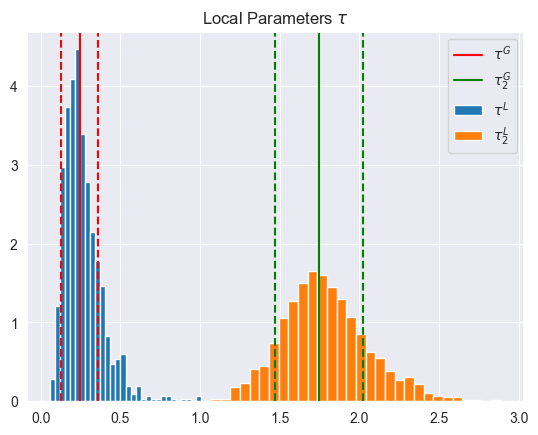

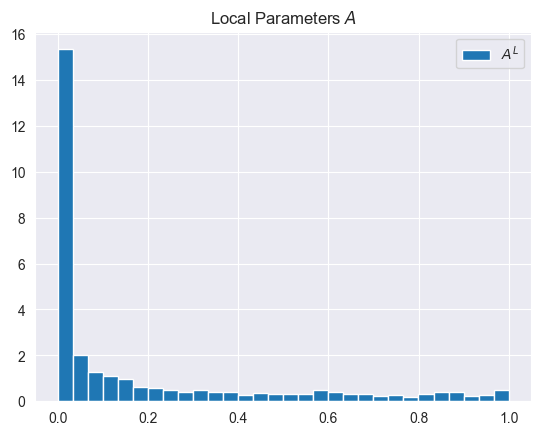

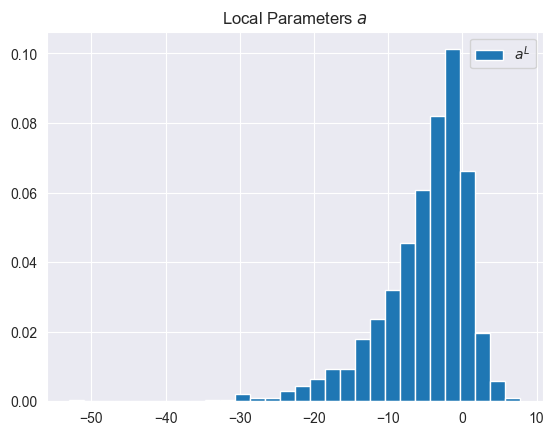

In [73]:
global_sample = prior.sample_global()
local_samples = prior.sample_local(1000)
tau_std = prior.get_local_variances()
tau_L1_std = tau_std['tau_L1_std']
tau_L2_std = tau_std['tau_L2_std']

tau_L = local_samples['tau_L']
tau_L_2 = local_samples['tau_L_2']
log_delta_tau_L = local_samples['log_delta_tau_L']
A_L = local_samples['A_L']
a_l = local_samples['a_l']

tau_G = np.exp(global_sample['log_tau_G'])
tau_G2 = tau_G + np.exp(global_sample['log_delta_tau_G'])

plt.title(r'Local Parameters $\tau$')
plt.axvline(tau_G, color='red', linestyle='-', label=r'$\tau^G$')
plt.axvline(tau_G-tau_L1_std, color='red', linestyle='--')
plt.axvline(tau_G+tau_L1_std, color='red', linestyle='--')
plt.axvline(tau_G2, color='green', linestyle='-', label=r'$\tau^G_2$')
plt.axvline(tau_G2-tau_L2_std, color='green', linestyle='--')
plt.axvline(tau_G2+tau_L2_std, color='green', linestyle='--')
plt.hist(tau_L, bins=30, density=True, label=r'$\tau^L$')
plt.hist(tau_L_2, bins=30, density=True, label=r'$\tau^L_2$')
plt.legend()
plt.show()

plt.title(r'Local Parameters $A$')
plt.hist(A_L, bins=30, density=True, label=r'$A^L$')
plt.legend()
plt.show()

plt.title(r'Local Parameters $a$')
plt.hist(a_l, bins=30, density=True, label=r'$a^L$')
plt.legend()
plt.show()

In [65]:
global_sample.keys()

dict_keys(['log_tau_G', 'log_sigma_tau_G', 'log_delta_tau_G', 'log_delta_sigma_tau_G', 'alpha_hyperprior', 'beta_hyperprior'])

In [50]:
# compute quantiles
np.quantile(tau_L, [0.025, 0.975]), np.quantile(tau_L_2, [0.025, 0.975])

(array([0.28464815, 1.29323953]), array([1.47746159, 2.71127121]))